In [5]:
%load_ext autoreload
%autoreload 2

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import seaborn as sns

import scipy.io as io
import re
from scipy.signal import resample as scipy_resample
from functools import partial
from tqdm import tqdm

from ephyspy.features import *  # contains available the features
from ephyspy.allen_sdk import ephys_extractor
from ephyspy.sweeps import EphysSweepSet, EphysSweep
from ephyspy.plot import *
from ephyspy.utils import *

import jupyter_black

jupyter_black.load()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from pandas import Series, DataFrame
from scipy.signal import filtfilt, bessel, iirnotch
from typing import Any


def filter_bad_sweeps(
    df: DataFrame,
    filt_df: DataFrame,
    align_by: str or Tuple[str, str],
    filter_by: str or Tuple[str, str],
) -> DataFrame:
    """Remove single sweeps (npoints,t,Ut,It) in dataframe as specified in another.

    Align two dataframes by a common column (does not neccesarily have to have
    the same name, only the same data) and merge them. Then enforce check which
    sweeps need to be excluded. Specified as a comma seperated string.

    Args:
        df: Dataframe to be filtered.
        filt_df: Dataframe for filtering.
        align_by: the same or two different columns that are used to align the
            two different dataframes.
        filter_by: columns to equate. see b)

    Returns:
        pd.Series with True where condition is met.
    """
    align_by = (align_by, align_by) if isinstance(align_by, str) else align_by
    filter_by = (filter_by, filter_by) if isinstance(filter_by, str) else filter_by
    orig_cols = df.columns

    if align_by[0] != align_by[1]:
        filt_df.rename({align_by[1]: align_by[0]}, inplace=True)
    df = pd.merge(df, filt_df, on=align_by[0], how="left")

    def clean_It(ts: ndarray, It: Callable, idxs2rm: List) -> Callable:
        """Remove stimuli corresponding to bad sweeps identified by idxs2rm."""
        if isinstance(ts, ndarray):
            ts = np.vstack([ts] + [ts[0]] * len(idxs2rm))
        return np.delete(It(ts), idxs2rm, axis=0)

    def sweep_filter(
        df: DataFrame, filter_by: str or Tuple[str, str]
    ) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
        if not isinstance(df[filter_by], str):  # catches nans
            return df.npoints, df.t, df.Ut, df.It
        else:
            rm = [int(x) - 1 for x in df[filter_by].split(",")]
            keep = [x for x in range(df.Ut.shape[0]) if x not in rm]
            return (
                df.npoints[keep],
                df.t[keep],
                df.Ut[keep],
                partial(clean_It, It=df.It, idxs2rm=rm),
            )

    if not df.empty:
        df[["npoints", "t", "Ut", "It"]] = df.apply(
            lambda x: sweep_filter(x, filter_by[0]), axis=1, result_type="expand"
        )
        df = df[df[filter_by[0]] != "all"].reset_index()[orig_cols]

    return df


def trange2t(t: ndarray) -> ndarray:
    """Transform array with tranges to time array.

    Args:
        t: time ranges in the format t=[[t0,tend,dt],...]

    Return:
        time array of form t=[[t0,t1,...,tN],...].
    """
    assert t.shape[1] == 3, "trange needs to have format: t=[[t0,tend,dt],...]"
    t = t.copy()
    if np.any(np.diff(t[:, 1])) > 0:  # catch different len tranges of ramps
        t[:, 1] = t[-1, 1]
    return np.vstack([np.arange(*ts) for ts in t])


def mat2dicts(mat: Dict) -> List[Dict]:
    """Takes io.loadmat outputs for ephys data and does some preprocessing.

    Args:
        mat: output dicts of io.loadmat with squeeze_me=True,
            chars_as_strings=True, mat_dtype=False, simplify_cells=True.

    Returns:
        stack of preprocessed dictionaries."""
    dcts = []
    num_recs = len(re.findall("chan[1-9]+", ",".join(mat.keys())))
    for n in range(num_recs):
        head = mat[f"head{n+1}"]
        chan = mat[f"chan{n+1}"]

        # manual refmt and clean
        chan["adc"] = chan["adc"].T.astype(float)
        chan["adc"] = (
            chan["adc"] if chan["adc"].ndim > 1 else chan["adc"].reshape(1, -1)
        )
        chan["tim"] = chan["tim"].astype(float)
        chan.pop("mrk")

        fname = head.pop("source").pop("name")  # remove source info
        head["cell"] = re.findall(r"[^\/\\]+(?=\.)", fname)[0]  # filename -> cellname
        keys2pop = [
            [
                "tim",
                "Channeltype",
                "Patch",
                "channeltype",
                "channeltypeFcn",
                "classifier",
                "comment",
                "embeddeddata",
                "markerclass",
                "Environment",
                "mapstructure",
            ],
            ["Func", "Labels", "MultiInterval", "Multiplex", "TargetClass"],
        ]
        for key in keys2pop[0]:
            head.pop(key)
        for key in keys2pop[1]:
            head["adc"].pop(key)
        head.update(head.pop("adc"))
        head["label"] = head.pop("Group")["Label"]
        head["Npoints"] = (
            np.array([head["Npoints"]])
            if not isinstance(head["Npoints"], np.ndarray)
            else head["Npoints"]
        )

        head.update(chan)
        dcts.append(head)

    return dcts


def t2trange(t: ndarray) -> ndarray:
    """Transform time array to array with trange params.

    Args:
        t: time array of form t=[[t0,t1,...,tN],...].

    Return:
        time ranges in the format t=[[t0,tend,dt],...]
    """

    def ensure_correct_t_len(t):
        t0 = t[:, 0]
        tN = t[:, -1]
        dt = t[:, 1] - t0

        l_b4 = t.shape[1]
        l_after = len(np.arange(t0[0], tN[0], dt[0]))
        tN -= (l_after - l_b4) * dt
        return t0, tN, dt

    assert t.shape[1] != 3, "t needs to have format: t=[[t0,t1,...,tN],...]"
    t0, tN, dt = ensure_correct_t_len(t)
    return np.vstack([t0, tN, dt]).T


def get_regex_filter(col: str, regex: str, case_sensitive=False) -> Callable:
    """return filter for regexs in particular column of a dataframe.

    If regex is found, the value at the index is True, else False.

    Args:
        df: Dataframe for filtering.
        col: col name to filter.
        regex: regular expression that is matched for values in the column.

    Returns:
        Callable that takes df and returns Series that contains True/False if regex is matched in col.
    """
    match_regex = lambda x: x.str.contains(regex, regex=True)
    if case_sensitive:
        return lambda df: match_regex(df[col])
    else:
        return lambda df: match_regex(df[col].str.lower())


def import_mats(fpaths: List[str], filter_func: Optional[Callable] = None) -> DataFrame:
    r"""Import and reformat .mat files with electrophysiological data.

    Imports all files in given in fpaths. Each .mat file must at least contain
    keys 'chan1' & 'head1' to be amenable to this function.

    The information that is contained within 'head[i]' and 'chan[i]' is parsed
    and a dataframe is constructed that contains the header and data for each
    recording.

    This includes (pruned to contain only useful entries):
    cell: filename / name of the cell
    channel: channel of the recording
    label: type of recording (fp = firing pattern)
    dc: offset current
    npoints: number of timepoints
    t: timepoints
    Ut: voltage traces for different stimuli
    It: different stimuli

    The function takes care of rescaling the data in t, U and matches the stimuli
    to the voltage traces (assuming Ut roughly flat -> I=0, and increasing/decreasing
    I in 20pA steps around that). It also selects only traces that have labels
    containing 'fp', 'sAP' or 'ramp'.

    To save memory the output is returned as:
    t = [[t0,tend,dt],...] assuming equal spacing of timebins. (num_sweeps, 3)
    Ut with shape (num_sweeps, $N_t$)
    It as function that returns array of shape (num_sweeps, $N_t$) for every t
    Instead of as:
    t = (num_sweeps,$N_t$)
    Ut = (num_sweeps, $N_t$)
    It = (num_sweeps, $N_t$)
    Then `unzip` can be used to obtain arrays of the same shapes.

    Args:
        fpaths: list of paths to matfiles to import.
        filter_func: applies filter to imported mats. Can save memory to get rid
            of unwanted recordings already during import.

    Returns:
        header_df: dataframe containing header information and data for the
            electrophysiological recordings.
    """
    dfs = []
    for fpath in tqdm(fpaths, desc="importing"):
        mat = io.loadmat(
            fpath,
            squeeze_me=True,
            chars_as_strings=True,
            mat_dtype=False,
            simplify_cells=True,
        )
        dcts = mat2dicts(mat)
        df = pd.DataFrame(dcts)

        # pre-filter (i.e. remove Imons, EPSPs, EPSCs) -> more memory efficient in for loop, faster outside!
        unused_data_filter = get_regex_filter("label", "epsp|epsc|spont")
        filtered_df = filter_df(df, unused_data_filter(df), True)
        if filter_func is not None:
            pre_filter = (
                (lambda df: pd.Series([False] * len(df)))
                if filter_func is None
                else filter_func
            )
            filtered_df = filter_df(filtered_df, pre_filter)

        dfs.append(filtered_df)

    df = pd.concat(dfs).reset_index(drop=True)

    enough_sweeps = df["adc"].apply(lambda x: x.shape[0] > 2)
    df = filter_df(df, enough_sweeps)

    # rescale
    def rescale_Ut(y, unit, lims):
        unit = 1 if unit in ["mV", "pA"] else 1000
        xmin, xmax = lims[0] * unit, lims[1] * unit
        ymin, ymax = np.min(y), np.max(y)
        return (xmax - xmin) / (ymax - ymin) * (y - ymin) + xmin

    def rescale_t(t, dt_in, npoints):
        tN = (np.diff(t) * 1e-6).reshape(-1, 1)
        t0 = np.zeros_like(tN)
        dt = dt_in * np.ones_like(tN) * 1000
        l_t = [len(np.arange(t0_i, tN_i, dt_i)) for t0_i, tN_i, dt_i in zip(t0, tN, dt)]
        l_t = np.array(l_t).reshape(-1, 1)
        dl_t = l_t - npoints.reshape(-1, 1)
        tN -= dl_t * (dt - 1e-10)  # somehow prevents numerical errors
        trange = np.hstack([t0, tN, dt])
        return trange

    def rescale(x):
        rescaled_Ut = rescale_Ut(x.adc, x.Units, x.YLim)
        dt = np.prod(x.SampleInterval)
        rescaled_t = rescale_t(x.tim, dt, x.Npoints)
        return rescaled_t, rescaled_Ut

    # TODO: Decide how to handle signals of different length! (i.e. ramp)
    # TODO: signals -> 0 to nans according to npoints
    tqdm.pandas(desc="rescaling")
    df[["tim", "adc"]] = df.progress_apply(rescale, axis=1, result_type="expand")

    # rename cols and remove obsolete cols
    df.rename(
        columns={"adc": "Ut", "tim": "t", "DC": "dc", "Npoints": "npoints"},
        inplace=True,
    )
    df = df[["cell", "dc", "channel", "label", "npoints", "t", "Ut"]]

    # stimuli
    def vectorize_stim_inputs(*args):
        is_number = lambda x: isinstance(x, float) or isinstance(x, int)
        as_array = lambda x: np.array(x) if is_number(x) else x

        def get_reshaped_array(x):
            x = as_array(x)
            if x.ndim == 0:
                return x.reshape(1, 1)
            elif x.ndim == 1:
                return x.reshape(-1, 1)
            else:
                return x

        args = [get_reshaped_array(a) for a in args]
        dims = [x.shape[0] if x.ndim > 0 else 0 for x in args]

        for i, (a, d) in enumerate(zip(args, dims)):
            if a.shape[0] != max(dims):
                a = np.vstack([a] * max(dims))
            args[i] = a
        return args

    def I_square(t, I, t_on, t_off):
        t, I, t_on, t_off = vectorize_stim_inputs(t, I, t_on, t_off)
        is_on = np.logical_and(t_on <= t, t <= t_off).astype(float)
        return I * is_on

    def I_ramp(t, t_on=100, t_off=1100):
        t, t_on, t_off = vectorize_stim_inputs(t, t_on, t_off)

        is_on = np.logical_and(t_on <= t, t <= t_off).astype(float)
        return 25 / 1000 * (t - t_on) * is_on

    def I_sAP(t, I=2000, t_on=100, t_off=102):
        return I_square(t, I, t_on, t_off)

    # add stimulus
    def add_stimuli(U, label, npoints):
        U = U if U.ndim > 1 else U.reshape(1, -1)
        num_sweeps = U.shape[0]
        stim_types = {
            35000: (200, 1200),
            28000: (200, 1200),
            20000: (200, 800),
            25000: (100, 700),
        }
        if "ramp" in label.lower():
            stim = stim_types[npoints[0]]
            t_off_0 = (
                1200 if "Ramp" in label else 1100
            )  # capitalized stimuli start later for some reason
            t_offs = np.cumsum([t_off_0] + [500] * (num_sweeps - 1))
            stimulus = partial(I_ramp, t_on=200, t_off=t_offs)
            return stimulus

        elif "fp" in label.lower():
            stim = stim_types[npoints[0]]
            I0_idx = np.argmin(np.var(U, axis=1))
            I = np.arange(-20 * I0_idx, 20 * (num_sweeps - I0_idx), 20).reshape(-1, 1)
            stimulus = partial(I_square, I=I, t_on=stim[0], t_off=stim[1])
            return stimulus

        elif "ap" in label.lower():
            t_on = (
                200 if "AP" in label or "Cell" in label else 100
            )  # capitalized stimuli start later for some reason
            t_off = t_on + 2
            stimulus = partial(
                I_sAP, I=2000 * np.ones(num_sweeps), t_on=t_on, t_off=t_off
            )
            return stimulus

    df["It"] = df.apply(lambda x: add_stimuli(x.Ut, x.label, x.npoints), axis=1)

    return df


def get_df_filter(
    filt_df: DataFrame,
    align_by: str or Tuple[str, str],
    filter_by: str or Tuple[str, str],
    val: Any = None,
) -> Series:
    """filter one dataframe by the column of another.

    Align two dataframes by a common column (does not neccesarily have to have
    the same name, only the same data) and merge them. Then enforce that either:
    a) True if rows contain a specified value
    b) True if values in two different columns specified in filter by are equal.

    Args:
        df: Dataframe to be filtered.
        filt_df: Dataframe for filtering.
        align_by: the same or two different columns that are used to align the
            two different dataframes.
        filter_by: columns to equate. see b)
        val: value to enforce. see a)

    Returns:
        Callable that takes df and returns Series which is True where condition is met.
    """
    align_by = (align_by, align_by) if isinstance(align_by, str) else align_by
    filter_by = (filter_by, filter_by) if isinstance(filter_by, str) else filter_by

    if align_by[0] != align_by[1]:
        filt_df.rename({align_by[1]: align_by[0]}, inplace=True)

    def df_filter(df):
        i_prev = df[align_by[0]]
        df = pd.merge(df, filt_df, on=align_by[0], how="left")
        i_now = df[align_by[0]]

        assert len(i_now) == len(i_prev), "Check for duplicate entries"
        assert all(i_now == i_prev), "Incorrect alignment of indices"
        if val is None:
            return df[filter_by[0]] == df[filter_by[1]]
        else:
            return df[filter_by[0]] == val

    return df_filter


def get_std_signal_filter(trange, ut, filt_cutoff=1, notch=None):
    """convenience function to configure basic ephys signal filter."""
    dt = trange[0, -1]
    b, a = bessel(4, filt_cutoff, fs=1 / dt)
    ut = filtfilt(b, a, ut)
    if notch is not None:
        b, a = iirnotch(notch, 1.5, fs=1e3 / dt)
        ut = filtfilt(b, a, ut)
    return ut


def filter_df(
    df: DataFrame,
    filter_mask: Series or Callable,
    negate: bool = False,
    reset_index: bool = True,
) -> DataFrame:
    """Convenience function to apply filter to dataframe.

    Applies df.loc[filter_mask] or df.loc[~filter_mask]

    Args:
        df: Dataframe for filtering.
        filter_mask: filter in the form of a boolean pd.Series.
        negate: Wether to include or exclude row if filter == True.
        reset_index: Whether to reset the index after filtering.

    Returns:
        filtered dataframe.
    """
    if isinstance(filter_mask, Callable):
        filter_mask = filter_mask(df)
    reindex = lambda df: df.reset_index(drop=True) if reset_index else df
    if negate:
        return reindex(df.loc[~filter_mask])
    else:
        return reindex(df.loc[filter_mask])


def preprocess_fp_data(
    fp_data: DataFrame,
    metadata: Optional[DataFrame] = None,
    filt_cutoff: int = 1,
) -> DataFrame:
    """Apply preprocessing steps to dataframe with firing pattern data.

    Part of the ephys pipeline. Applies varies hardcoded filters to the fp data.

    Args:
        fp_data: dataframe holding the firing pattern data.
        metadata: dataframe holding the metadata.
        filt_cutoff: 4 pole bessel filter cutoff freq in kHz.

    Returns:
        preprocessed fp data.
    """

    if metadata is not None:
        # fp_data = filter_df(
        #     fp_data, get_df_filter(metadata, "cell", "Subgroup", val="Adult")
        # )
        fp_data = filter_df(
            fp_data, get_df_filter(metadata, "cell", ("channel", "firing pattern"))
        )
        fp_data = filter_df(
            fp_data,
            get_df_filter(metadata, "cell", "delete", val="Delete"),
            negate=True,
        )
        fp_data = filter_bad_sweeps(fp_data, metadata, "cell", "fp_rm_sweep")

    fp_data = filter_df(fp_data, fp_data["npoints"].apply(lambda x: len(x) > 5))

    if filt_cutoff is not None and len(fp_data) > 0:
        fp_filter = lambda df: get_std_signal_filter(df.t, df.Ut, filt_cutoff)
        fp_data["Ut"] = fp_data.apply(fp_filter, axis=1)
    return fp_data


ROOT = "../smartseq3/data/"
PATH_batch1 = ROOT + "ephys_batch1/Ephys Mat Data"
PATH_batch2 = ROOT + "ephys_batch2/Ephys Mat Data"

# metadata
metadata_batch1 = pd.read_excel(
    ROOT + "ephys_batch1/cell_metadata_batch1.xlsx", dtype={"fp_rm_sweep": str}
)
metadata_batch2 = pd.read_excel(
    ROOT + "ephys_batch2/cell_metadata_batch2.xlsx", dtype={"fp_rm_sweep": str}
)
cols = [
    "cell",
    "delete",
    "delete reason",
    "single AP",
    "RAMP_AP",
    "firing pattern",
    "fp_rm_sweep",
]
metadata = pd.concat([metadata_batch1[cols + ["Subgroup"]], metadata_batch2[cols]])

# file paths
fpaths_batch1 = [
    os.path.join(PATH_batch1, f) for f in os.listdir(PATH_batch1) if ".mat" in f
]
fpaths_batch2 = [
    os.path.join(PATH_batch2, f) for f in os.listdir(PATH_batch2) if ".mat" in f
]
fpaths = fpaths_batch1 + fpaths_batch2


data = import_mats(fpaths[:10])
fp_data = filter_df(data, get_regex_filter("label", "fp"))
fp_data = preprocess_fp_data(fp_data, metadata, 5)

rescaling: 100%|██████████| 33/33 [00:00<00:00, 359.63it/s]


In [7]:
ft2ft = {
    "tau": "Membrane time constant (ms)",
    "v_baseline": "Baseline voltage (mV)",
    "v_rest": "Resting membrane potential (mV)",
    "r_input": "Input resistance (MOhm)",
    "ap_thresh": "AP threshold (mV)",
    "ap_amp": "AP amplitude (mV)",
    "ap_width": "AP width (ms)",
    "ap_udr": "Upstroke-to-downstroke ratio",
    "ap_ahp": "Afterhyperpolarization (mV)",
    "ap_adp": "Afterdepolarization (mV)",
    "isi_adapt": "ISI adaptation index",
    "num_ap": "Max number of APs",
    "rheobase": "Rheobase (pA)",
    "sag_ratio": "Sag ratio",
    "sag_fraction": "Sag fraction",
    "sag": "Sag (mV)",
    "sag_time": "Sag time (ms)",
    "sag_area": "Sag area (mV*s)",
    "latency": "Latency (ms)",
    "ap_freq_adapt": "Spike frequency adaptation",
    "burstiness": "Burstiness",
    "wildness": "Wildness",
    "rebound": "Rebound (mV)",
    "rebound_latency": "Rebound latency (ms)",
    "rebound_area": "Rebound Area (mV*ms)",
    "rebound_aps": "Rebound number of APs",
    "rebound_avg": "Avg rebound (mV)",
    "dfdi": "df/dI (Hz/pA)",
    "slow_hyperpolarization": "Slow hyperpolarization (mV)",
    "ap_peak": "AP peak (mV)",
    "ap_trough": "AP trough (mV)",
    "isi_cv": "ISI coefficient of variation",
    "isi_ff": "ISI Fano factor",
    "ap_ff": "AP Fano factor",
    "ap_cv": "AP coefficient of variation",
    "ap_amp_adapt": "AP amplitude adaptation index",
    "ap_amp_avg_adapt": "AP amplitude average adaptation index",
    "isi_adapt_avg": "ISI average adaptation index",
}
ft2ft = {v: k for k, v in ft2ft.items()}

In [13]:
available_sweep_features()

{'ap_adp': ephyspy.features.sweep_features.AP_ADP,
 'ap_ahp': ephyspy.features.sweep_features.AP_AHP,
 'ap_cv': ephyspy.features.sweep_features.AP_CV,
 'ap_ff': ephyspy.features.sweep_features.AP_FF,
 'ap_udr': ephyspy.features.sweep_features.AP_UDR,
 'ap_amp': ephyspy.features.sweep_features.AP_amp,
 'ap_amp_adapt': ephyspy.features.sweep_features.AP_amp_adapt,
 'ap_amp_adapt_avg': ephyspy.features.sweep_features.AP_amp_adapt_avg,
 'ap_amp_slope': ephyspy.features.sweep_features.AP_amp_slope,
 'ap_freq': ephyspy.features.sweep_features.AP_freq,
 'ap_freq_adapt': ephyspy.features.sweep_features.AP_freq_adapt,
 'ap_latency': ephyspy.features.sweep_features.AP_latency,
 'ap_peak': ephyspy.features.sweep_features.AP_peak,
 'ap_thresh': ephyspy.features.sweep_features.AP_thresh,
 'ap_trough': ephyspy.features.sweep_features.AP_trough,
 'ap_width': ephyspy.features.sweep_features.AP_width,
 'burstiness': ephyspy.features.sweep_features.Burstiness,
 'isi': ephyspy.features.sweep_features.ISI

In [8]:
# df = []
# for i, (cell, t_set, u_set, i_set, dc) in tqdm(
#     fp_data[["cell", "t", "Ut", "It", "dc"]].iterrows()
# ):
#     t_set = trange2t(t_set)
#     i_set = i_set(t_set)
#     t_set *= 1e-3
#     metadata = {"dc_offset": dc}

#     # create sweepset
#     test_sweepset = EphysSweepSet(
#         t_set,
#         u_set,
#         i_set,
#         filter=5,
#         metadata=metadata,
#     )

#     test_sweepset.add_features(available_spike_features())
#     test_sweepset.add_features(available_sweepset_features())
#     sweepset_features = test_sweepset.get_features(num_workers=3)
#     sweepset_features["cell"] = cell
#     df.append(sweepset_features)

# # new_fts = pd.DataFrame(df)
# # new_fts.to_csv("fts_new.csv")

In [9]:
# new_fts = pd.DataFrame(df)
# old_fts = pd.read_csv("../smartseq3/data/ephys_fts_all_1kHz.csv", index_col=0)
# drop_cols = [c for c in old_fts.columns if "Ramp" in c or "sAP" in c]
# old_fts.drop(drop_cols, axis=1, inplace=True)
# old_fts = old_fts[old_fts["cell"].isin(new_fts["cell"])]
# old_fts.rename(ft2ft, inplace=True, axis=1)
# old_fts = old_fts.drop("Latency @ +20pA current (ms)", axis=1)
# old_fts["ap_width"] = old_fts["ap_width"] / 1000
# old_fts["wildness"] = old_fts["wildness"].replace(0, np.nan)
# old_fts["rebound_aps"] = old_fts["rebound_aps"].replace(0, np.nan)
# common_fts = list(set(old_fts.columns).intersection(set(new_fts.columns)))
# common_fts.remove("cell")

In [10]:
t_set, u_set, i_set, dc, cell = fp_data[["t", "Ut", "It", "dc", "cell"]].iloc[0]
t_set = trange2t(t_set)
i_set = i_set(t_set)
t_set *= 1e-3
metadata = {"dc_offset": dc}

# create sweepset
test_sweepset = EphysSweepSet(
    t_set,
    u_set,
    i_set,
    filter=1,
    metadata=metadata,
)

test_sweepset.add_features(available_spike_features())
# test_sweepset.add_features(available_sweep_features())
test_sweepset.add_features(available_sweepset_features())
sweepset_features = test_sweepset.get_features()

In [8]:
new_fts = pd.read_csv("./fts_new.csv", index_col=0)
old_fts = pd.read_csv("./fts_old.csv", index_col=0)
old_fts["rebound_aps"] = old_fts["rebound_aps"].replace(0, np.nan)
old_fts["burstiness"] = old_fts["burstiness"].replace(0, np.nan)
common_fts = list(set(old_fts.columns).intersection(set(new_fts.columns)))
common_fts.remove("cell")

for ft in ["ap_ff", "isi_ff", "ap_cv", "isi_cv"]:
    old_fts[ft] = old_fts[ft].apply(np.log)
    new_fts[ft] = new_fts[ft].apply(np.log)

In [75]:
# features to doublecheck:
# - ap_udr (FIXED)
# - slow_hyperpolarization (DIFFERENT, ONE EXCLUDES HYPERPOLARIZATION TRACES)
# - wildness (NEW WILDNESS IS BETTER)
# - rebound_aps (FIXED)
# - ap_adp (FIXED)
# - sag_area (Should be well behaved. Two mistakes: 1. only sags < 4mV were calculated instead of > 4mV, 2, units of t are different)
# - burstiness (!?)

# sweeps to doublecheck:
# 270. 274, 334 (FIXED)
# 292, 403 <- results of burst detection and division by 0 (not critical)

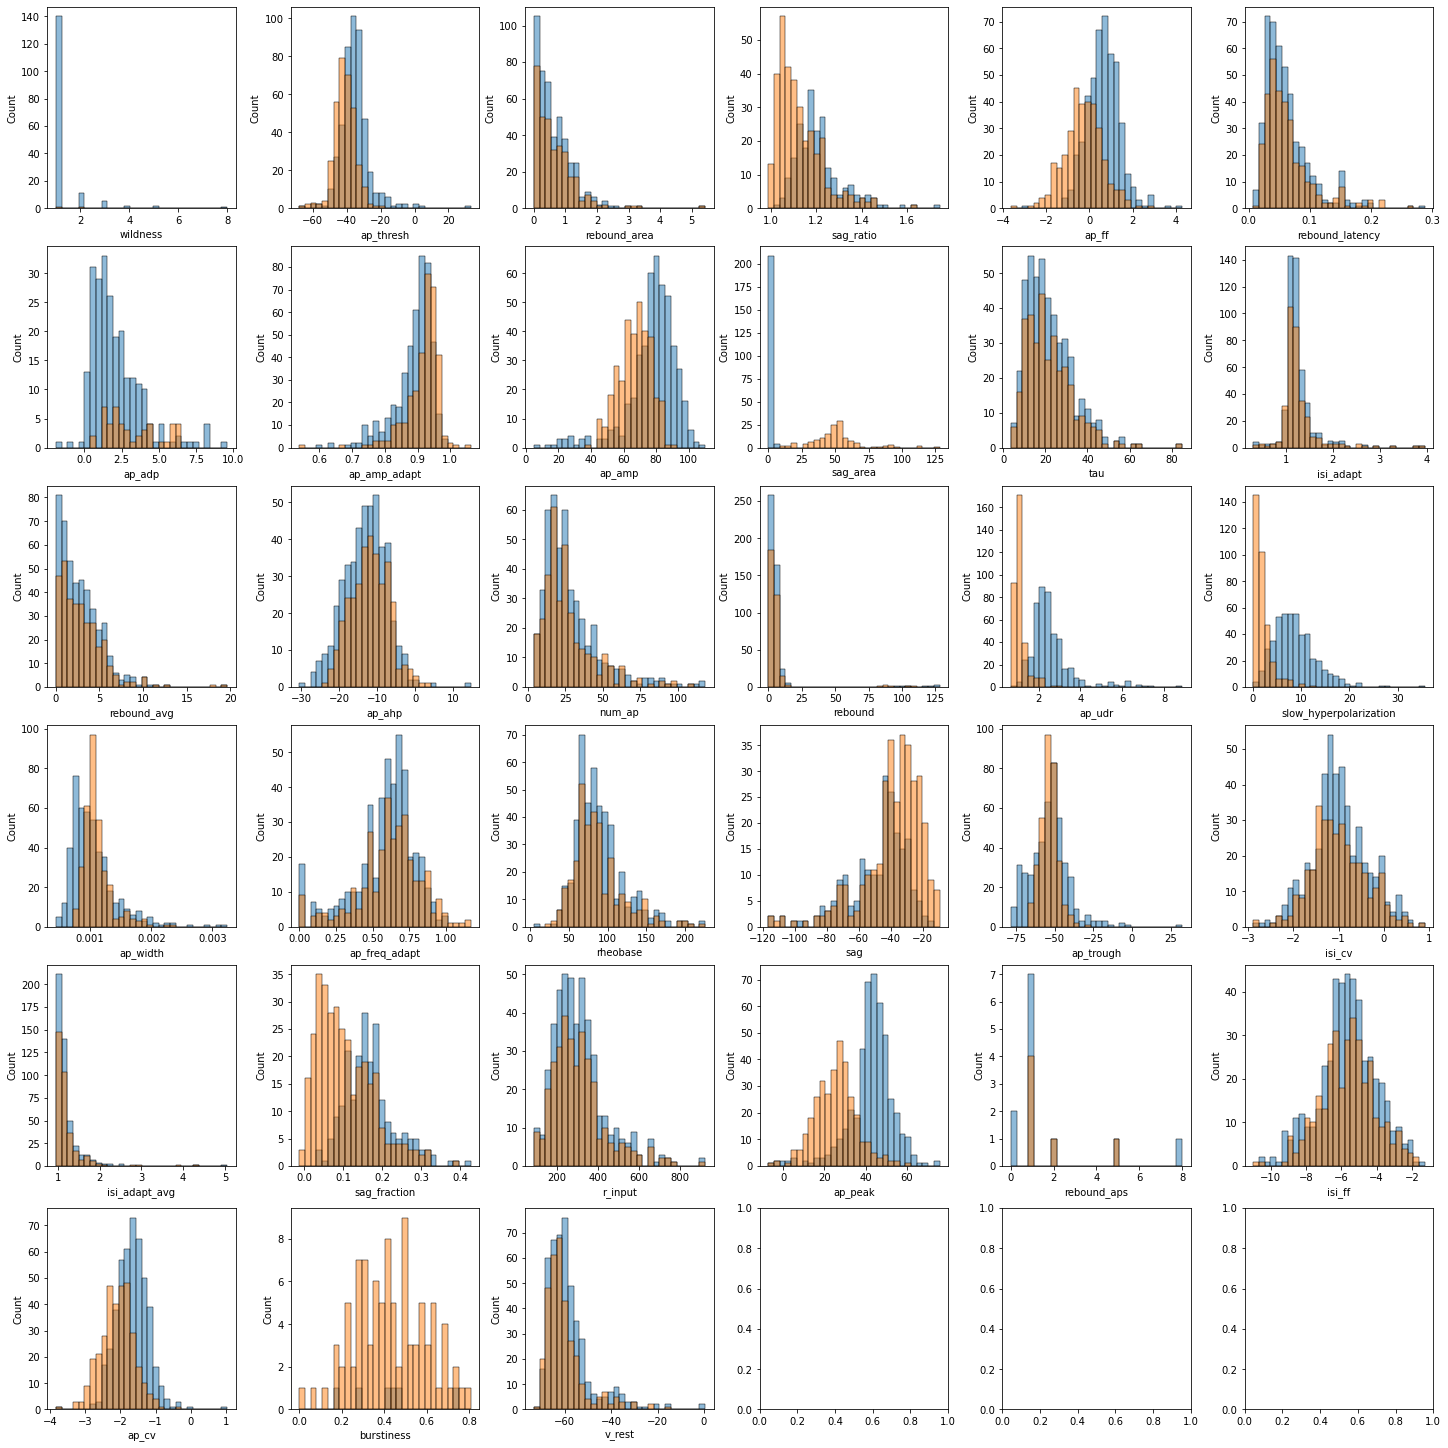

In [9]:
fig, axes = plt.subplots(6, 6, figsize=(20, 20), constrained_layout=True)
for ax, ft in zip(axes.flat, common_fts):
    all_fts = pd.concat([new_fts[ft], old_fts[ft]])
    lb, ub = all_fts.min(), all_fts.max()
    bins = np.histogram_bin_edges(new_fts[ft], bins=30, range=(lb, ub))
    sns.histplot(data=new_fts[ft], ax=ax, alpha=0.5, bins=bins, label="new")
    sns.histplot(data=old_fts[ft], ax=ax, alpha=0.5, bins=bins, label="old")
plt.show()

In [5]:
# IDEA FOR IMPROVED API:
# - Only have ephys feature (merge sweepset and sweep feature kinda): This takes sweeps and sweepsets,
#   if sweepset is given, it will compute the features for each sweep and then
#   compute the sweepset features. If only one sweep is given, it will compute
#   the only one feature
# - call aggregate() which will return  aggregated feature object / value

# add multithreading to sweepset broadcasting (use mutliprocessing.Pool)